In [1]:
%matplotlib inline
import os

from IPython.display import display, Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage
from scipy import misc

In [2]:
imageFolder = "images"

In [3]:
imagePaths = [x for x in os.listdir(imageFolder) if x.split('.')[-1] == "png"]

print 'number of images in folder:', len(imagePaths)

number of images in folder: 1


loading: images/00 (394)-0.png


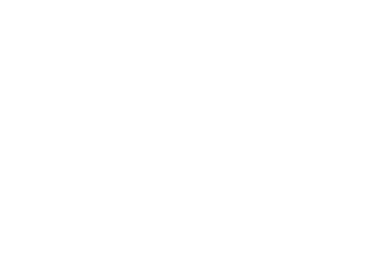

In [4]:
image_size = 128  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
image_dim = 1

def load_image(imagePath):
    print "loading:", os.path.join(imageFolder, imagePath)
    
    image_data = ndimage.imread(os.path.join(imageFolder, imagePath)).astype(float)
            
    if image_dim == 1 and len(image_data.shape) > 2: 
        image_data = image_data[:,:,0] #convert to BW
        
    # resize to target resolution if necessary
    if image_data.shape[0] != image_size:
        image_data = misc.imresize(image_data, (image_size, image_size), interp='nearest')

    # normalize
    image_data = (image_data - image_data.mean()) / image_data.std() / 2
    plt.axis('off')
    
    return image_data

img = load_image(imagePaths[0])
# imshow(img, cmap = plt.get_cmap('gray'), vmin = -1, vmax = 1,  interpolation='nearest')

In [5]:
def point_distance(x1, y1, x2, y2):
    return ((x1-x2)**2.0 + (y1-y2)**2.0)**(0.5)

##### Line algorithm

In [6]:
pathReduction = .2

In [7]:
import math

def plotLine(x0,y0,x1,y1,output):
    #plots line to numpy array using Bresenham's Line Algorithm
    #https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    
    xs = []
    ys = []
    
    if x0 > x1:
        x_max = int(x0)
        y_max = int(y0)
        x_min = int(x1)
        y_min = int(y1)
    else:
        x_max = int(x1)
        y_max = int(y1)
        x_min = int(x0)
        y_min = int(y0)

    w = output.shape[1]
    h = output.shape[0]

    dx = x_max - x_min
    dy = y_max - y_min

    if dx == 0:
        #exception for vertical lines
        for y in range(y_min,y_max):
            output[y,x_min] += pathReduction
            xs.append(x_min)
            ys.append(y)
    else:
        error = -1.0
        d_error = abs( float(dy)/float(dx) )
        y = y_min
        for x in range(x_min,x_max):
            if y >= h or y < 0:
                continue
            elif x >= w or x < 0:
                continue
            output[y,x] += pathReduction
            
            xs.append(x)
            ys.append(y)
            
            error += d_error
            while error >= 0.0:
                if(dy > 0):
                    y += 1
                else:
                    y-= 1
                error -= 1.0
                output[y,x] += pathReduction
            
                xs.append(x)
                ys.append(y)

    return output, xs, ys

In [13]:
blurAmount = 3

In [14]:
from PIL import Image, ImageFilter

def blurImage(d):
    
    d1 = (d + 1) / 2.0 * 255.0 # convert to 0-255 range
    img = Image.fromarray( d1 )
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    im_processed = img.filter(ImageFilter.GaussianBlur(radius=blurAmount))#.filter(ImageFilter.EDGE_ENHANCE_MORE)
    n = np.array(im_processed.getdata()).reshape(im_processed.size[0], im_processed.size[1], 3)
    
    n1 = n[:,:,0]
    n1 = (n1 / 255.0 * 2.0) - 1 # convert to -1-1 range
    return n1

In [77]:
searchRad = 10
numGCODESteps = 400

spread_line = 3
spread_point = 10

line_mult = 0.2
point_mult = 0.0

In [78]:
def findNextPoint(currX, currY, sizeX, sizeY, img):
    
    currFrame = img[max(0,currY-searchRad):min(currY+searchRad, sizeY),
                        max(0,currX-searchRad):min(currX+searchRad, sizeX)]

    # get search frame offset from current position
    offX = currX - max(0,currX-searchRad)
    offY = currY - max(0,currY-searchRad)

    # find minimum value
    minIndecesY = currFrame.argmin(axis=0)
    minValsY = np.amin(currFrame,axis=0)
    minIndexX = minValsY.argmin(axis=0)
    minIndexY = minIndecesY[minIndexX]

    # get next position
    nextX = currX - offX + minIndexX
    nextY = currY - offY + minIndexY
    
    return nextX, nextY

In [79]:
def traceImage(img):

    sizeX = img.shape[1]
    sizeY = img.shape[0]

    img = blurImage(img)

    currX = int(sizeX/2)
    currY = int(sizeY/2)

    # setup platting canvas
    canvas = np.zeros((sizeY,sizeX))

    codes = []

    for k in range(numGCODESteps):

        nextX, nextY = findNextPoint(currX, currY, sizeX, sizeY, img)

        # plot line on canvas and get line pixels
        canvas, xs, ys = plotLine( currX, currY, nextX, nextY, canvas)

        # set next location to current location
        currX = nextX
        currY = nextY

        # put GCODES in list
        codes.append(currX/float(sizeX)*200-100)
        codes.append(currY/float(sizeY)*200-100)

        for indx in range(len(xs)):

            _x = xs[indx]
            _y = ys[indx]

            for j in range(max(0, (_y - spread_line)), min(sizeY, (_y + spread_line))):
                for i in range(max(0, (_x - spread_line)), min(sizeX, (_x + spread_line))):
                    calc = img[j, i] + (line_mult * math.exp((-point_distance(i,j,_x,_y)**2)/(2*(spread_line / 2.5)**2)))
                    img[j, i] = min(1, calc)

        for j in range(max(0, (currY - spread_point)), min(sizeY, (currY + spread_point))):
                for i in range(max(0, (currX - spread_point)), min(sizeX, (currX + spread_point))):
                    calc = img[j, i] + (point_mult * math.exp((-point_distance(i,j,currX,currY)**2)/(2*(spread_point / 2.5)**2)))
                    img[j, i] = min(1, calc)

    plt.subplot(1, 2, 1)
    imshow(img, cmap = plt.get_cmap('gray'), vmin = -1, vmax = 1,  interpolation='nearest')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    canvas = (canvas - 1) * -1
    imshow(canvas, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 1,  interpolation='nearest')
    plt.axis('off')

    return np.asarray(codes)

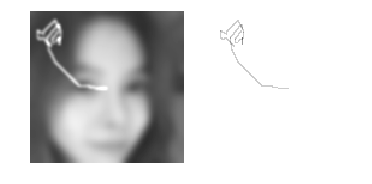

In [106]:
numGCODESteps = 25
y_train = traceImage(img)